# Starbucks Promotion Segmentation - Modeling

## Contents

### [Section I: Dependencies and Data](#load)
### [Section II: Data Preprocessing](#prep)
  ##### [1. Extract offers](#prep1)
  ##### [2. Encode categorical variables](#prep2)
  ##### [3. Create target label](#prep3)
  ##### [4. Balance target classes](#prep4)
  ##### [5. Split data into 3 sets](#prep5)
  ##### [6. Multicollinearity](#prep6)
  ##### [7. Normalize values](#prep7)
### [Section III: Modeling](#clfr)
  ##### [1. Feature correlation with target](#clfr1)
  ##### [2. Evaluation functions](#clfr2)
  ##### [3. Logistic regression](#clfr3)
  ##### [4. K-nearest neighbors](#clfr4)
  ##### [5. Support vector machines](#clfr5)
  ##### [6. Decision tree](#clfr6)
  ##### [7. Random forest](#clfr7)
  ##### [8. LightGBM](#clfr8)
  ##### [9. Final classifier](#clfr9)
### [Section IV: Conclusion](#conc)

## Introduction
In this notebook, we will build a classifier to predict whether a customer will respond to an offer. This predictor will help us decide whether we should send users a particular offer. The input of this classifier includes an offer, a user, and additional features relating to the offer and user. It will produce a binary output predicting whether or not the user will complete the offer.

## Machine Learning Models
I will be trying 6 different machine learning models and tuning their hyperparameters with grid search. The model with the best predictive performance will be our final classifier.

#### Logistic regression
This will be our baseline model for predictions. Logistic regression is a very fast algorithm that is easy to implement and interpret. It doesn't require much hyperparameter tuning and provides feature coefficients to help us understand how important each feature was in making predictions. These are all reasons logistic regression is a staple in binary classification.

#### K-nearest neighbors (KNN)
This is one of the more inefficient algorithms in both time (very slow) and space (it stores the training dataset). However, we are working with a relatively small dataset so KNN is a viable solution here. Its classification method is easy to understand: for any new data point, it finds the closest k neighbors in the n-dimensional space (n being the number of features) and classifies the new data point as neighbors' majority class. And as a non-parametric model, it makes no assumptions about the data.

#### Support vector machine (SVM)
This is another slow algorithm that doesn't scale well with bigger data sets, but again, we are working with a relatively small dataset. Although it is less interpretable, SVM is robust to nonlinear and nonseparable data, and also less prone to overfitting and the effects of outliers.

#### Decision tree
Like logistic regression, this is a very fast and highly interpretable algorithm. Even with 10 times more hyperparameter combinations in the grid search, tuning a decision tree model would still be orders of magnitude faster than an SVM model. And it also provides feature importance coefficients like logistic regression. It's definitely another staple in classification. A major downside of this model is that it is very prone to overfitting, but that won't be a problem here. If hyperparameter tuning doesn't fix the problem of overfitting, ensembling trees will, which is why we are also including random forest and LightGBM.

#### Random forest
As mentioned above, random forest addresses the problem of overfitting by ensembling many trees and voting for the outpuut, although this does come at a high cost. It considerably increases runtime and computational resources, but it does generally produce more accurate predictions than decision tree in addition to being less prone to overfitting. Like decision tree, we're able to see the feature importances, which may aid in feature selection. And like SVM, it's also robust to nonlinear data and outliers.

#### Light gradient boosting machine (LightGBM)
This is another ensemble method that uses the results of building many decision trees. But unlikely random forest where each tree is independent of each other, LightGBM uses gradient boosting to optimize the tree-building process by minimizing the error from the previous tree. This optimization process is the reason gradient boosting algorithms are among the best predictors in machine learning. Since there are a lot more hyperparameters to tune for LightGBM, grid search is just not feasible. Instead, we will be using Optuna, which uses Bayesian optimization to tune parameters. As we are using 2 optimization processes here, I suspect LightGBM will have the best predictive performance.

#### Metrics
The models will be evaluated based on their prediction accuracy. As the accuracy alone can often be misleading in classification problems, we will also be looking at the:
- F1 score - the harmonic mean of precision and recall
- Confusion matrix - shows the number of true positives, true negatives, false positives, and false negatives in the predictions

This way, we can get a closer look at the predictions and ensure that there isn't a major imbalance in the predicted classes. Ideally, we'd like to see an equal precision and recall, which would yield an F1 score that is also the same. This means that the number of false positives and false negatives would have to be fairly close.

However, in this case, we are willing to accept a recall that is greater than the precision (but not the other way around), as long as it does not negatively affect the accuracy and F1 score. In other words, if there was a minor class imbalance, we would prefer that the classifier predicts with more false positives than false negatives. This is because it would be better to send out offers to customers that wouldn't respond to them, than to NOT send out offers to customers that would respond.

## <a id="load">Section I: Dependencies and data</a>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import plotly.subplots as subplots
sns.set()

import gc
import joblib
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss,\
                            plot_confusion_matrix, classification_report as report

import lightgbm as lgb
import optuna

In [2]:
# Data
offers = pd.read_pickle('../data/out2/offers.pkl')
offers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148431 entries, 0 to 148430
Data columns (total 31 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   index             148431 non-null  int64         
 1   event             148431 non-null  object        
 2   time              148431 non-null  int64         
 3   offer_id          148431 non-null  int64         
 4   user_id           148431 non-null  int64         
 5   amount            148431 non-null  float64       
 6   reward            148431 non-null  int64         
 7   difficulty        148431 non-null  int64         
 8   duration          148431 non-null  int64         
 9   offer_type        148431 non-null  object        
 10  mobile            148431 non-null  int64         
 11  social            148431 non-null  int64         
 12  web               148431 non-null  int64         
 13  expire_time       148431 non-null  int64         
 14  oid_

## <a id="prep">Section II: Data Preprocessing</a>

### <a id="prep1">1. Extract offers</a>

Since we are trying to predict whether a user will respond to an offer if we send it to them, the only data of interest are "offer received" events.

In [3]:
df = offers.query('event == "offer received"').copy()
df.head(2)

,index,event,time,offer_id,user_id,amount,reward,difficulty,duration,offer_type,...,signup_date,signup_year,age_group,income_group,frequency,monetary,tenure,customer_tier,cluster,customer_cluster
0,0,offer received,0,7,2,0.0,5,5,7,bogo,...,2017-05-09,2017,5,5,7,159.27,15,Silver,0,Female low spenders
1,2,offer received,0,5,3,0.0,2,10,7,discount,...,2018-04-26,2018,4,3,3,57.73,4,Bronze,3,Male low spenders


In [4]:
# Drop columns that won't be used
to_drop = ['index', 'event', 'time', 'amount', 'expire_time', 'oid_uid',
           'signup_date', 'signup_year', 'customer_tier', 'customer_cluster', 'cluster']
df.drop(to_drop, axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66501 entries, 0 to 132146
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   offer_id      66501 non-null  int64  
 1   user_id       66501 non-null  int64  
 2   reward        66501 non-null  int64  
 3   difficulty    66501 non-null  int64  
 4   duration      66501 non-null  int64  
 5   offer_type    66501 non-null  object 
 6   mobile        66501 non-null  int64  
 7   social        66501 non-null  int64  
 8   web           66501 non-null  int64  
 9   viewed        66501 non-null  int64  
 10  completed     66501 non-null  int64  
 11  group         66501 non-null  int64  
 12  gender        66501 non-null  object 
 13  age           66501 non-null  int64  
 14  income        66501 non-null  int64  
 15  age_group     66501 non-null  int64  
 16  income_group  66501 non-null  int64  
 17  frequency     66501 non-null  int64  
 18  monetary      66501 non-n

### <a id="prep2">2. Encode categorical variables</a>

In [5]:
# Encode offer type
df['info_offer'] = df.offer_type.apply(lambda t: int(t == 'informational'))
df['disc_offer'] = df.offer_type.apply(lambda t: int(t == 'discount'))
df['bogo_offer'] = df.offer_type.apply(lambda t: int(t == 'bogo'))
print(df.info_offer.sum(), df.disc_offer.sum(), df.bogo_offer.sum())
df.offer_type.value_counts()

13300 26664 26537


discount         26664
bogo             26537
informational    13300
Name: offer_type, dtype: int64

In [6]:
# Encode gender
df['male'] = df.gender.apply(lambda g: int(g == 'M'))
print(df.male.sum())
df.gender.value_counts()

38129


M    38129
F    27456
O      916
Name: gender, dtype: int64

In [7]:
# Drop categorical columns
df.drop(['offer_type', 'gender'], axis=1, inplace=True)
df.shape

(66501, 22)

##### I decided to one-hot encode `offer_type` because it has low cardinality. For `gender` I created only 1 binary feature to indicate whether the user was male (the majority class) because the "other" gender is a rare category.

### <a id="prep3">3. Create target label</a>

The target label is whether or not the user viewed and completed the offered. If a user completed an offer without viewing it first, that user was not aware of the offer and spent the money anyway, which means there was no point in sending an offer to that customer.

In [8]:
df['target'] = df.apply(lambda o: int(o.viewed == o.completed == 1), axis=1)
df.target.value_counts()

0    38659
1    27842
Name: target, dtype: int64

In [9]:
to_drop = ['offer_id', 'user_id', 'age_group', 'income_group', 'viewed', 'completed', 'group']
df.drop(to_drop, axis=1, inplace=True)
df.shape

(66501, 16)

### <a id="prep4">4. Balance target classes</a>

In [10]:
# Downsample class 0
df = pd.concat([df.query('target == 1'), df.query('target == 0').sample(27842, random_state=0)]).sort_index()
print(df.shape)
df.head(2)

(55684, 16)


,reward,difficulty,duration,mobile,social,web,age,income,frequency,monetary,tenure,info_offer,disc_offer,bogo_offer,male,target
0,5,5,7,1,0,1,75,100000,7,159.27,15,0,0,1,0,1
1,2,10,7,1,0,1,68,70000,3,57.73,4,0,1,0,1,0


In [11]:
# # Upsample class 1
# df = pd.concat([df, df.query('target == 1').sample(38659 - 27842, random_state=0)]).reset_index(drop=True)
# print(df.shape)
# df.head(2)

In [12]:
df.target.value_counts()

1    27842
0    27842
Name: target, dtype: int64

### <a id="prep5">5. Split data into 3 sets</a>

In [13]:
X = df.drop('target', axis=1).copy() # features
y = df['target'].copy() # target label
X.shape, y.shape

((55684, 15), (55684,))

In [14]:
# First split - train set (60%)
X_train, X_vt, y_train, y_vt = train_test_split(X, y, train_size=0.6, random_state=0)
X_train.shape, X_vt.shape, y_train.shape, y_vt.shape

((33410, 15), (22274, 15), (33410,), (22274,))

In [15]:
# Second split - validation and test sets (20% each)
X_val, X_test, y_val, y_test = train_test_split(X_vt, y_vt, train_size=0.5, random_state=0)
X_val.shape, X_test.shape, y_val.shape, y_test.shape

((11137, 15), (11137, 15), (11137,), (11137,))

In [16]:
# Class ratio for train and test sets
print('Proportion of offers completed in:')
print('Train set:', y_train.mean())
print('Validation set:', y_val.mean())
print('Test set:', y_test.mean())

Proportion of offers completed in:
Train set: 0.5022747680335229
Validation set: 0.48846188381072103
Test set: 0.5047140163419234


### <a id="prep6">6. Multicollinearity</a>

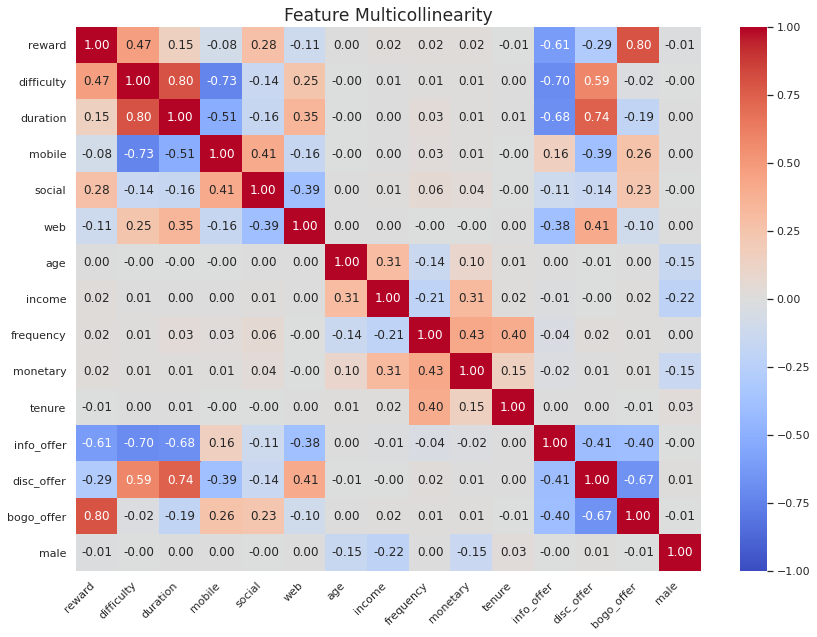

In [17]:
plt.figure(figsize=(14, 10))
sns.heatmap(X_train.corr(), annot=True, vmin=-1, vmax=1, fmt='.2f', cmap='coolwarm')
plt.title('Feature Multicollinearity', fontsize='x-large')
plt.xticks(rotation=45, ha='right');

In [18]:
high_corr = ['duration', 'mobile', 'info_offer', 'disc_offer', 'bogo_offer']
low_corr_feats = np.setdiff1d(X_train.columns, high_corr)
low_corr_feats

array(['age', 'difficulty', 'frequency', 'income', 'male', 'monetary',
       'reward', 'social', 'tenure', 'web'], dtype=object)

##### High multicollinearity was found with the 3 `offer type` binary features, 3 `channel` binary features, and `duration` feature. These features won't be dropped as they may be good predictors for tree-based classifiers, but they will be omitted from classification algorithms where there is an assumption of no multicollinearity.

### <a id="prep7">7. Normalize values</a>

In [19]:
# Normalize train set
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_train_scaled.head(2)

,reward,difficulty,duration,mobile,social,web,age,income,frequency,monetary,tenure,info_offer,disc_offer,bogo_offer,male
0,-0.342294,-0.114874,0.225353,0.32117,0.787324,0.500935,0.315473,-1.285855,0.557083,-0.309021,0.122169,-0.500327,1.211932,-0.807565,0.87684
1,-0.637000,0.436317,1.582750,0.32117,0.787324,0.500935,0.488569,-0.357779,1.773999,1.147328,0.982399,-0.500327,1.211932,-0.807565,0.87684


In [20]:
# Normalize validation set
X_val_scaled = scaler.transform(X_val)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns)
X_val_scaled.head(2)

,reward,difficulty,duration,mobile,social,web,age,income,frequency,monetary,tenure,info_offer,disc_offer,bogo_offer,male
0,0.247117,-0.482334,-0.679579,0.321170,0.787324,0.500935,1.527147,2.287238,-0.051376,0.551361,-0.523004,-0.500327,-0.825129,1.238291,0.87684
1,0.247117,2.273619,1.582750,-3.113619,-1.270125,0.500935,-0.492310,-0.357779,-1.673931,-0.932033,-0.451318,-0.500327,1.211932,-0.807565,0.87684


In [21]:
# Normalize test set
X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)
X_test_scaled.head(2)

,reward,difficulty,duration,mobile,social,web,age,income,frequency,monetary,tenure,info_offer,disc_offer,bogo_offer,male
0,-0.637000,0.436317,0.225353,0.32117,-1.270125,0.500935,-1.357791,-1.425066,-0.862653,-0.874035,-1.168177,-0.500327,1.211932,-0.807565,0.87684
1,0.247117,-0.482334,-0.679579,0.32117,0.787324,0.500935,1.469448,0.384682,-1.065473,-0.477633,-0.738062,-0.500327,-0.825129,1.238291,0.87684


In [22]:
del X_vt, y_vt, high_corr, to_drop
gc.collect()

18097

##### With the data preprocessed, we are left with 2 feature sets:
1. Set 1 with 8 features (no features with high multicollinearity) - `age`, `difficulty`, `frequency`, `income`, `male`, `monetary`, `reward`, `tenure`
2. Set 2 with 15 features - the features in set 1 plus `duration`, `mobile`, `social`, `web`, `info_offers`, `disc_offer`, `bogo_offer`

## <a id="clfr">Section III: Modeling</a>

### <a id="clfr1">1. Feature correlation with target</a>

In [23]:
# Correlation with target
target_corr = X_train.assign(target = y_train).corr().iloc[-1, :-1].sort_values(ascending=False)
target_corr

frequency     0.288992
monetary      0.283196
social        0.221276
mobile        0.159169
tenure        0.155593
income        0.115111
age           0.057705
disc_offer    0.039475
info_offer   -0.003099
web          -0.007438
duration     -0.015443
bogo_offer   -0.037109
reward       -0.057826
male         -0.090205
difficulty   -0.098174
Name: target, dtype: float64

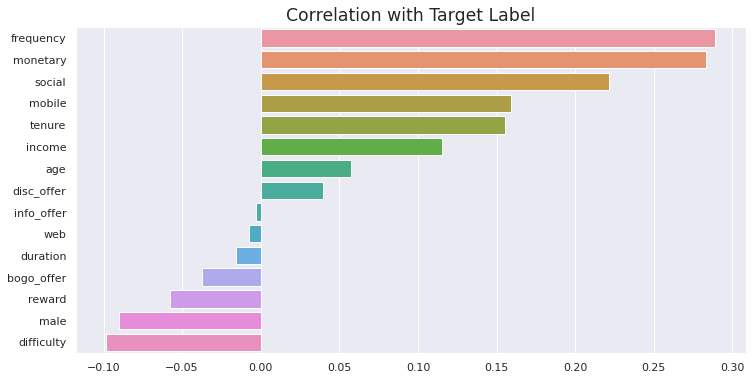

In [24]:
plt.figure(figsize=(12, 6))
sns.barplot(x=target_corr.values, y=target_corr.index)
plt.title('Correlation with Target Label', fontsize='x-large');

##### If we were using a linear model, it looks like the spending habits of a customer would be the best predictor of whether or not they would complete an offer.

### <a id="clfr2">2. Evaluation functions</a>

In [25]:
def model_eval(train_pred, val_pred, test_pred=None,
               train_true=y_train, val_true=y_val, test_true=y_test):
    
    '''
    Get the accuracy and ROC-AUC scores of the train, validation, and test sets.
    
    Args:
        (1) train_pred (array-like) - predictions on training set
        (2) val_pred (array-like) - predictions on validation set
        (3) test_pred (array-like) - predictions on test set
        (4) train_true (array-like) - true labels from train set
        (5) val_true (array-like) - true labels from validation set
        (6) test_true (array-like) - true labels from test set
        
    Returns:
        Accuracy and ROC-AUC scores of the train, validation, and test sets (Pandas dataframe)
    '''
    
    metrics = dict()
    
    if train_pred is not None:
        metrics['train'] = [accuracy_score(train_true, train_pred)]
        metrics['train'].append(roc_auc_score(train_true, train_pred))
        
    if val_pred is not None:
        metrics['validation'] = [accuracy_score(val_true, val_pred)]
        metrics['validation'].append(roc_auc_score(val_true, val_pred))
        
    if test_pred is not None:
        metrics['test'] = [accuracy_score(test_true, test_pred)]
        metrics['test'].append(roc_auc_score(test_true, test_pred))
        
    return pd.DataFrame(metrics, index=['accuracy', 'ROC-AUC score']).T

In [26]:
def plot_confusion(estimator, n_subplots, train_X, val_X, test_X=None,
                   train_y=y_train, val_y=y_val, test_y=y_test, color='Blues'):
    
    '''
    Plot a heatmap of the confusion matrix for the train, validation, and test sets.
    
    Args:
        (1) estimator (Sklearn estimator) - fitted classifier
        (2) n_subplots (int) - number of sets to plot for
        (3) train_X (Pandas dataframe) - X from training set
        (4) val_X (Pandas dataframe) - X from validation set
        (5) test_X (Pandas dataframe) - X from test set
        (6) train_y (Pandas dataframe) - y from training set
        (7) val_y (Pandas dataframe) - y from validation set
        (8) test_y (Pandas dataframe) - y from test set
        
    Returns: None.
    '''
    
    fig, ax = plt.subplots(1, n_subplots, figsize=(15, 3))
    i = 0
    
    if train_X is not None:
        plot_confusion_matrix(estimator, train_X, train_y, cmap=color, ax=ax[i])
        ax[i].set_title('Train Confusion Matrix')
        ax[i].grid(False)
        i += 1
        
    if val_X is not None:
        plot_confusion_matrix(estimator, val_X, val_y, cmap=color, ax=ax[i])
        ax[i].set_title('Validation Confusion Matrix')
        ax[i].grid(False)
        i += 1
        
    if test_X is not None:
        plot_confusion_matrix(estimator, test_X, test_y, cmap=color, ax=ax[i])
        ax[i].set_title('Test Confusion Matrix')
        ax[i].grid(False)

### <a id="clfr3">3. Logistic regression</a>

In [27]:
X_train_scaled_sub = X_train_scaled[low_corr_feats]
X_val_scaled_sub = X_val_scaled[low_corr_feats]
X_test_scaled_sub = X_test_scaled[low_corr_feats]
X_train_scaled_sub.shape, X_val_scaled_sub.shape, X_test_scaled_sub.shape

((33410, 10), (11137, 10), (11137, 10))

In [28]:
%%time

# Grid Search
lr = LogisticRegression(random_state=0)
lr_params = {'C': np.logspace(-3, 1, 10),
             'penalty': ['l1', 'l2']}

lr_search = GridSearchCV(lr, lr_params, scoring='roc_auc', cv=10, n_jobs=4, verbose=2)
lr_search.fit(X_train_scaled_sub, y_train)
print(lr_search.best_score_)
print(lr_search.best_params_)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  46 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    2.2s finished


0.7643357510667421
{'C': 0.0027825594022071257, 'penalty': 'l2'}
CPU times: user 328 ms, sys: 391 ms, total: 719 ms
Wall time: 2.34 s


In [29]:
# Train model
lr = lr_search.best_estimator_
lr.fit(X_train_scaled_sub, y_train)

# Make predictions
lr_train_pred = lr.predict(X_train_scaled_sub)
lr_val_pred = lr.predict(X_val_scaled_sub)

# Evaluate predictions
print(report(y_train, lr_train_pred))
print(report(y_val, lr_val_pred))

              precision    recall  f1-score   support

           0       0.69      0.71      0.70     16629
           1       0.71      0.69      0.70     16781

    accuracy                           0.70     33410
   macro avg       0.70      0.70      0.70     33410
weighted avg       0.70      0.70      0.70     33410

              precision    recall  f1-score   support

           0       0.70      0.71      0.71      5697
           1       0.69      0.68      0.69      5440

    accuracy                           0.70     11137
   macro avg       0.70      0.70      0.70     11137
weighted avg       0.70      0.70      0.70     11137



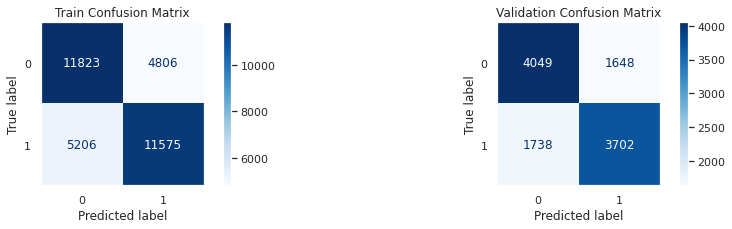

In [30]:
# Confusion matrix
plot_confusion(lr, 2, X_train_scaled_sub, X_val_scaled_sub)

In [31]:
# Coefficients
pd.Series(lr.coef_[0], index=X_train_scaled_sub.columns).sort_values(ascending=False)

social        0.583153
frequency     0.481342
monetary      0.412479
web           0.201281
income        0.194424
tenure        0.102440
age           0.085600
difficulty   -0.093795
male         -0.103252
reward       -0.242256
dtype: float64

##### The logistic regression model achieved an prediction accuracy and f1-score of 0.70 for both the training and validation sets. Since the target classes were balanced beforehand, we can see that there isn't much of a disparity between the number of false negatives and false positives.

##### The only hyperparameters tuned were `penalty` and `C`, both of which are for regularization. Regularization shrinks the magnitude of feature coefficients in order to control the complexity of the model, which in turn prevents it from overfitting. The best values were:
- `penalty`: L2 - this adds the squared coefficient to the loss function
- `C`: 0.00278 - reciprocal of regularization strength (i.e. the smaller the `C` value, the more regularization)

##### It looks like the `social`, `frequency`, and `monetary` features have the most predictive power in this model. The posistive relationship between the customer's spending habits and their likelihood of completing an offer agrees with the analysis from the previous notebooks, but it's interesting to see that sending the offer through social media has an even greater importance here. Perhaps this is the main channel in which customers are responding to offers.

##### Surprisingly, `reward` has a negative coefficient, which is counterintuitive because one would expect that reward has a positive relationship with offer completion. Of course, this doesn't imply that lowering rewards would increase offer completions. It could just be that informational offers (which have 0 `reward`) are pulling this coefficient in the negative direction.

### <a id="clfr4">4. K-nearest Neighbors</a>

CPU times: user 1min 14s, sys: 46.9 ms, total: 1min 14s
Wall time: 1min 14s


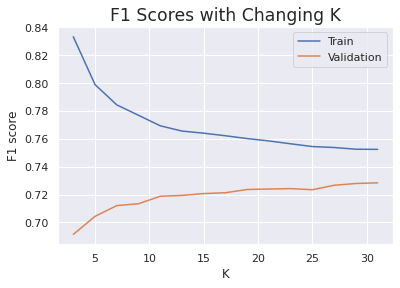

In [32]:
%%time

# Find optimal range for K
auc_train, auc_val = [], []
for k in range(3, 33, 2):
    
    # Train model
    knn_k = KNeighborsClassifier(n_neighbors=k)
    knn_k.fit(X_train_scaled, y_train)
    
    # Make predictions
    k_train_pred = knn_k.predict(X_train_scaled)
    k_val_pred = knn_k.predict(X_val_scaled)
    
    # F1 scores
    auc_train.append(f1_score(y_train, k_train_pred))
    auc_val.append(f1_score(y_val, k_val_pred))

# Plot scores
sns.lineplot(x=range(3, 33, 2), y=auc_train)
sns.lineplot(x=range(3, 33, 2), y=auc_val)
plt.title('F1 Scores with Changing K', fontsize='x-large')
plt.ylabel('F1 score')
plt.xlabel('K')
plt.legend(['Train', 'Validation']);

In [33]:
%%time

# Grid search
knn = KNeighborsClassifier()
knn_params = {'n_neighbors': [5, 10, 30, 50],
              'p': [1, 2, 3, 4]}

knn_search = GridSearchCV(knn, knn_params, scoring='roc_auc', cv=4, n_jobs=4, verbose=2)
knn_search.fit(X_train_scaled, y_train)
print(knn_search.best_score_)
print(knn_search.best_params_)

Fitting 4 folds for each of 16 candidates, totalling 64 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   18.1s
[Parallel(n_jobs=4)]: Done  64 out of  64 | elapsed:   55.3s finished


0.8069483746389617
{'n_neighbors': 50, 'p': 1}
CPU times: user 156 ms, sys: 78.1 ms, total: 234 ms
Wall time: 55.5 s


In [34]:
# Train model
knn = knn_search.best_estimator_
knn.fit(X_train_scaled, y_train)

# Make predictions
knn_train_pred = knn.predict(X_train_scaled)
knn_val_pred = knn.predict(X_val_scaled)

# Evaluate predictions
print(report(y_train, knn_train_pred))
print(report(y_val, knn_val_pred))

              precision    recall  f1-score   support

           0       0.74      0.74      0.74     16629
           1       0.74      0.75      0.75     16781

    accuracy                           0.74     33410
   macro avg       0.74      0.74      0.74     33410
weighted avg       0.74      0.74      0.74     33410

              precision    recall  f1-score   support

           0       0.74      0.73      0.73      5697
           1       0.72      0.73      0.73      5440

    accuracy                           0.73     11137
   macro avg       0.73      0.73      0.73     11137
weighted avg       0.73      0.73      0.73     11137



##### The K-nearest neighbors algorithm did a bit better than logistic regression in making predictions on the validation set, with a f1-score of 0.73.

##### Once again, only 2 parameters were tuned: `n_neighbors` (the core of this algorithm) and `p` (the polynomial for the distance function). The best values were:
- `n_neighbors`: 50 - this means that in order to classify any new data point, KNN will find its 50 closest neighbors and take the major class of the neighbors
    - As seen in the line plot of F1 scores for the train and validation sets with a varying k, the validation set's f1-score converges to somewhere around 0.74 when going beyond a k of 30
    - I stopped at 50 neighbors in the parameter grid because any more would add unnecessary runtime for a minimal gain in score
- `p`: 1 - a polynomial of 1 means the Manhattan distance will be used to compute distances between data points

### <a id="clfr5">5. Support Vector Machines</a>

In [35]:
%%time

# Grid search
svc = SVC()
svc_params = {'C': np.logspace(-1, 3, 5),
              'gamma': np.logspace(-3, 1, 5)}

svc_search = GridSearchCV(svc, svc_params, scoring='roc_auc', cv=3, n_jobs=4, verbose=2)
svc_search.fit(X_train_scaled, y_train)
print(svc_search.best_score_)
print(svc_search.best_params_)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done  75 out of  75 | elapsed: 20.8min finished


0.8080061393878167
{'C': 100.0, 'gamma': 0.01}
CPU times: user 32.9 s, sys: 172 ms, total: 33.1 s
Wall time: 21min 20s


In [36]:
# Train model
svc = svc_search.best_estimator_
svc.fit(X_train_scaled, y_train)

# Make predictions
svc_train_pred = svc.predict(X_train_scaled)
svc_val_pred = svc.predict(X_val_scaled)

# Evaluate predictions
print(report(y_train, svc_train_pred))
print(report(y_val, svc_val_pred))

              precision    recall  f1-score   support

           0       0.76      0.70      0.73     16629
           1       0.72      0.78      0.75     16781

    accuracy                           0.74     33410
   macro avg       0.74      0.74      0.74     33410
weighted avg       0.74      0.74      0.74     33410

              precision    recall  f1-score   support

           0       0.77      0.69      0.73      5697
           1       0.71      0.78      0.74      5440

    accuracy                           0.74     11137
   macro avg       0.74      0.74      0.74     11137
weighted avg       0.74      0.74      0.74     11137



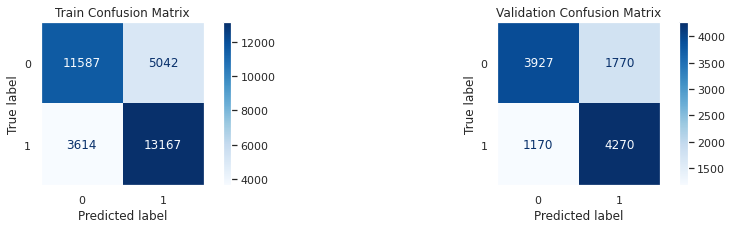

In [37]:
### Confusion matrix
plot_confusion(svc, 2, X_train_scaled, X_val_scaled)

##### Compared to KNN, SVM did slightly better overall with an f1-score of 0.74, but did have a prediction imbalance. Predictions of the positive class outnumbered the negative class at a ratio of 3 to 2. As discussed in the introduction, a bias towards the positive class is tolerable in this case. Once again, this is because we would prefer to send offers to customers who wouldn't respond to them than to fail to send to customers who would respond to them.

##### Even though it took quite a bit longer this time, still only 2 parameters were tuned:
- `C`: 100 - this is the same `C` as in logistic regression, i.e. the inverse of regularization strength
- `gamma`: 0.01 - this is the kernel coefficient used in refining the decision boundary, most often less than 1

### <a id="clfr6">6. Decision tree</a>

In [38]:
%%time

# Grid search
dt = DecisionTreeClassifier(random_state=0)
dt_params = {'max_features': [0.25, 0.5, 0.75, None],
             'max_depth': [8, 10, 12, None],
             'min_samples_split': [100, 60, 20, 2],
             'min_samples_leaf': [50, 30, 10, 1]}

dt_search = GridSearchCV(dt, dt_params, scoring='roc_auc', cv=4, n_jobs=4, verbose=2)
dt_search.fit(X_train_scaled, y_train)
print(dt_search.best_score_)
print(dt_search.best_params_)

Fitting 4 folds for each of 256 candidates, totalling 1024 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 1024 out of 1024 | elapsed:   12.8s finished


0.8134880223748231
{'max_depth': 8, 'max_features': 0.75, 'min_samples_leaf': 50, 'min_samples_split': 100}
CPU times: user 484 ms, sys: 141 ms, total: 625 ms
Wall time: 12.9 s


In [39]:
# Train model
dt = dt_search.best_estimator_
dt.fit(X_train_scaled, y_train)

# Make predictions
dt_train_pred = dt.predict(X_train_scaled)
dt_val_pred = dt.predict(X_val_scaled)

# Evaluate predictions
print(report(y_train, dt_train_pred))
print(report(y_val, dt_val_pred))

              precision    recall  f1-score   support

           0       0.77      0.70      0.73     16629
           1       0.73      0.79      0.76     16781

    accuracy                           0.75     33410
   macro avg       0.75      0.75      0.74     33410
weighted avg       0.75      0.75      0.75     33410

              precision    recall  f1-score   support

           0       0.76      0.69      0.73      5697
           1       0.71      0.77      0.74      5440

    accuracy                           0.73     11137
   macro avg       0.73      0.73      0.73     11137
weighted avg       0.73      0.73      0.73     11137



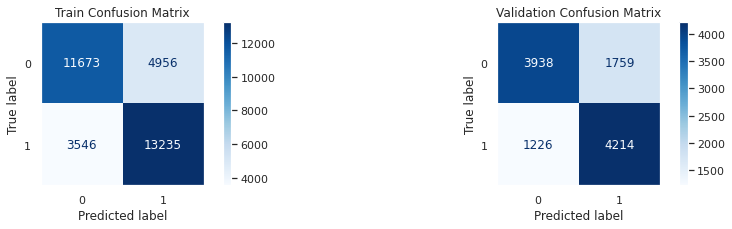

In [40]:
# Confusion matrix
plot_confusion(dt, 2, X_train_scaled, X_val_scaled)

In [41]:
# Feature importances
pd.Series(dt.feature_importances_, index=X_train_scaled.columns).sort_values(ascending=False)

monetary      0.602683
social        0.142341
frequency     0.075223
reward        0.058690
income        0.030498
duration      0.020246
tenure        0.017530
mobile        0.014008
age           0.013276
web           0.012084
difficulty    0.007509
info_offer    0.003628
male          0.000881
disc_offer    0.000801
bogo_offer    0.000603
dtype: float64

##### Just as with logistic regression, `monetary`, `social`, and `frequency` are the top 3 most important features, although not in the same order. So the decision tree algorithm agrees that the most important predictors are the user's spending habits and whether the offer was sent via social media.

##### If there was no limit to how deep the tree can go and no minimum amount of data points that can be in a leaf node, the tree would keep going until all the points in the training data has been classified perfectly. It would be highly specific to the training set and would fail to generalize well to new data. However, we can do something about this extreme case of overfitting. All 4 of the parameters tuned were to reduce overfitting, which was successful because we see a very close score for the training set and validation set: 0.75 and 0.74 respectively. The best parameters are:
- `max_features`: 0.75 - this limits the feature set to 75% on every split to add some randomness to the model
- `max_depth`: 8 - this limits the number of levels the tree can have to 8, which reduces the complexity of the model
- `min_samples_split`: 100 - this means that a node must have at least 100 data points in order for it to split
- `min_samples_leaf`: 50 - this means that all leaf nodes must have at least 50 data points, i.e. a node cannot be split if either its 2 resulting child nodes will have less than that

##### Decision tree made predictions with a slightly lower accuracy but similar imbalance as SVM. Now we will try to improve the predictions with ensembling.

### <a id="clfr7">7. Random forest</a>

In [42]:
%%time

# Grid search
rf = RandomForestClassifier(random_state=0)
rf_params = {'max_samples': [0.4, 0.6, 0.8, None],
             'max_features': [0.25, 0.5, 0.75, None],
             'max_depth': [8, 10, 12, None],
             'min_samples_split': [100, 60, 20, 2],
             'min_samples_leaf': [50, 30, 10, 1]}

rf_search = GridSearchCV(rf, rf_params, scoring='roc_auc', cv=4, n_jobs=4, verbose=2)
rf_search.fit(X_train_scaled, y_train)
print(rf_search.best_score_)
print(rf_search.best_params_)

Fitting 4 folds for each of 1024 candidates, totalling 4096 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    6.5s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   33.3s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:  3.8min
[Parallel(n_jobs=4)]: Done 1005 tasks      | elapsed:  8.2min
[Parallel(n_jobs=4)]: Done 1450 tasks      | elapsed: 10.9min
[Parallel(n_jobs=4)]: Done 1977 tasks      | elapsed: 17.4min
[Parallel(n_jobs=4)]: Done 2584 tasks      | elapsed: 22.9min
[Parallel(n_jobs=4)]: Done 3273 tasks      | elapsed: 30.6min
[Parallel(n_jobs=4)]: Done 4042 tasks      | elapsed: 39.8min
[Parallel(n_jobs=4)]: Done 4096 out of 4096 | elapsed: 40.9min finished


0.8253236660866843
{'max_depth': None, 'max_features': 0.5, 'max_samples': 0.8, 'min_samples_leaf': 10, 'min_samples_split': 100}
CPU times: user 9.84 s, sys: 2.08 s, total: 11.9 s
Wall time: 40min 59s


In [44]:
%%time

# Train model
rf = RandomForestClassifier(n_estimators=1000,
                            max_samples=0.6,
                            max_features=0.75,
                            max_depth=10,
                            min_samples_split=40,
                            min_samples_leaf=20,
                            random_state=0,
                            n_jobs=-1)
rf.fit(X_train_scaled, y_train)

# Make predictions
rf_train_pred = rf.predict(X_train_scaled)
rf_val_pred = rf.predict(X_val_scaled)

# Evaluate predictions
print(report(y_train, rf_train_pred))
print(report(y_val, rf_val_pred))

              precision    recall  f1-score   support

           0       0.79      0.72      0.76     16629
           1       0.75      0.81      0.78     16781

    accuracy                           0.77     33410
   macro avg       0.77      0.77      0.77     33410
weighted avg       0.77      0.77      0.77     33410

              precision    recall  f1-score   support

           0       0.78      0.70      0.74      5697
           1       0.72      0.79      0.75      5440

    accuracy                           0.74     11137
   macro avg       0.75      0.75      0.74     11137
weighted avg       0.75      0.74      0.74     11137

CPU times: user 48.7 s, sys: 781 ms, total: 49.5 s
Wall time: 4.3 s


In [45]:
# Feature importances
pd.Series(rf.feature_importances_, index=X_train_scaled.columns).sort_values(ascending=False)

monetary      0.483150
frequency     0.130321
social        0.113210
income        0.057603
reward        0.045159
tenure        0.039696
age           0.038830
difficulty    0.025503
disc_offer    0.024609
duration      0.014769
mobile        0.008493
web           0.006874
bogo_offer    0.005271
male          0.003972
info_offer    0.002541
dtype: float64

##### Since random forest is just ensembling decision trees, it's naturally to see that the top 3 features still haven't changed: `monetary`, `frequency`, and `social`, although the coefficients did change.

##### The same 4 parameters tuned with decision tree were done here as well with the same values. But there is 1 additional feature to vary here. We are adding `max_samples` to the grid to add more randomness to the model. This parameter limits the size of the training data each tree is trained on. With many trees being trained on different data and ensembling the results, we may get a very robust model. The best values are:
- `max_samples`: 0.6
- `max_features`: 0.75
- `max_depth`: 10
- `min_samples_split`: 40
- `min_samples_leaf`: 20

##### Random forest did do better than decision tree but unfortunately, it wasn't much of an improvement. Perhaps gradient boosting will have better luck.

### <a id="clfr8">8. LightGBM</a>

In [46]:
def lgb_objective(trial):
    
    '''
    Objective function for the hyperparameter optimization of LightGBM using Optuna.
    
    Args:
        trial (Optuna trial) - optimization trial
        
    Returns:
        ROC-AUC score (float).
    '''
    
    # Save study
    joblib.dump(lgb_study, '../data/out3/lgb_study.pkl')
    
    # LGB dataset objects
    dtrain = lgb.Dataset(X_train_scaled, label=y_train, params={'verbose': -1})
    dval = lgb.Dataset(X_val_scaled, label=y_val, params={'verbose': -1})
    
    # Parameter grid
    params = {
        'num_iterations': trial.suggest_int('num_iterations', 1_000, 20_000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-5, 1e2),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-5, 1e2),
        'max_depth': trial.suggest_int('max_depth', 2, 40),
        'num_leaves': trial.suggest_int('num_leaves', 2, 200),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 2, 400),
        'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 0.6, 1.4),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.5, 1.0),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
        'early_stopping_rounds': 40,
        'objective': 'binary',
        'seed': 0,
        'verbose': -1,
        'num_threads': -1
    }
    
    # Train model
    lgbm = lgb.train(params, dtrain, verbose_eval=False,
                     valid_sets=[dtrain, dval],
                     valid_names=['train', 'validation'])
    
    # Make predictions
    y_pred = lgbm.predict(X_val_scaled)
    y_pred = y_pred.round().astype(int)
    return roc_auc_score(y_val, y_pred)

In [47]:
# %%time

# # Enable logging
# optuna.logging.enable_default_handler()

# # Run study
# lgb_study = optuna.create_study(direction='maximize')
# lgb_study.optimize(lgb_objective, n_trials=500)

# print('Finished trials:', len(lgb_study.trials))
# print('Best trial:', lgb_study.best_trial.value)
# lgb_study.best_trial.params

In [48]:
# Load study
lgb_study = joblib.load('../data/out3/lgb_study.pkl')
print('Finished trials:', len(lgb_study.trials))
print('Best trial:', lgb_study.best_trial.value)
lgb_study.best_trial.params

Finished trials: 500
Best trial: 0.747961856214313


{'num_iterations': 4361,
 'learning_rate': 0.048336152780921626,
 'lambda_l1': 0.033937751997972394,
 'lambda_l2': 0.019309248988946422,
 'max_depth': 6,
 'num_leaves': 81,
 'min_data_in_leaf': 301,
 'scale_pos_weight': 0.9238722372110234,
 'bagging_fraction': 0.9106558812477173,
 'feature_fraction': 0.6637513756371946}

In [49]:
# Best parameters
lgb_params = lgb_study.best_trial.params
lgb_params['objective'] = 'binary'
lgb_params['seed'] = 0
lgb_params['verbose'] = -1
lgb_params['num_threads'] = -1

# Increase number of iterations and decrease learning rate by the same ratio
lgb_params['num_iterations'] = 20_000
lgb_params['learning_rate'] = 0.01

# LGB dataset objects
dtrain = lgb.Dataset(X_train_scaled, label=y_train, params={'verbose': -1})
dval = lgb.Dataset(X_val_scaled, label=y_val, params={'verbose': -1})

# Train model
lgbm = lgb.train(lgb_params, dtrain, verbose_eval=False)

# Make predictions
lgbm_train_pred = lgbm.predict(X_train_scaled)
lgbm_val_pred = lgbm.predict(X_val_scaled)

# Convert predictions to binary
lgbm_train_pred = lgbm_train_pred.round().astype(int)
lgbm_val_pred = lgbm_val_pred.round().astype(int)

# Evaluate predictions
print(report(y_train, lgbm_train_pred))
print(report(y_val, lgbm_val_pred))

/home/tri/miniconda3/envs/minds/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


              precision    recall  f1-score   support

           0       0.82      0.80      0.81     16629
           1       0.81      0.83      0.82     16781

    accuracy                           0.81     33410
   macro avg       0.81      0.81      0.81     33410
weighted avg       0.81      0.81      0.81     33410

              precision    recall  f1-score   support

           0       0.74      0.72      0.73      5697
           1       0.72      0.74      0.73      5440

    accuracy                           0.73     11137
   macro avg       0.73      0.73      0.73     11137
weighted avg       0.73      0.73      0.73     11137



In [50]:
pd.Series(lgbm.feature_importance(), index=X_train_scaled.columns).sort_values(ascending=False)

monetary      80589
income        67434
age           66320
tenure        57261
frequency     34790
reward        14500
difficulty    11467
duration      11058
male           6716
social         5287
disc_offer     2983
bogo_offer     2848
web            1901
mobile          417
info_offer      102
dtype: int32

##### Surprisingly, LightGBM did worse than random forest despite the optimization in tree building AND optimization in parameter tuning.

##### But interestingly, the top features are different here: `monetary`, `income`, `age`, and `tenure`. But all of the classifiers agree that `monetary` value is among the best predictors.

##### As mentioned in the introduction, there were a lot more parameters to tune with LightGBM, so grid search was out of the question. Instead, I used Optuna, which is better for 2 reasons: (1) it pulls parameter values from a distribution since it's not testing every single combination of features and (2) every successive trial uses previous trials as a prior in order to optimize the parameters. After running 500 trials of parameter optimization, I arrived at the following values:
- `num_iterations`: 4361 - number of trees built
- `learning_rate`: 0.0483 - step size for gradient boosting
- `scale_pos_weight`: 0.9239 - weight for positive class
- `lambda_l1`: 0.0339 - L1 penalty term (magnitude of coefficient)
- `lambda_l2`: 0.0193 - L2 penalty term (squared coefficient)
- `num_leaves`: 81 - maximum number of leaf nodes each tree can have
- `max_depth`: 6 - maximum number of levels each tree can grow to
- `min_data_in_leaf`: 301 - minimum number of data points that a leaf node can have
- `bagging_fraction`: 0.9107 - the proportion of the training data used in building each tree
- `feature_fraction`: 0.6638 - the proportion of the feature set to use in building each tree

##### From the beginning, I intended to use somewhere between 10k - 20k for the number of estimators. But since `num_iterations` and `learning_rate` are inversely related, I needed to see the ratio between the 2 values. Then I would increase the `num_iterations` and decrease the `learning_rate` by the same relative rate until it was in my desired range. And then we have `scale_pos_weight` which assigns a weight to the positive class, to deal with any class imbalance.

##### The remaining 7 parameters all help reduce overfitting. `Lambda_l1` and `lambda_l2` are the L1 and L2 regularization penalties. `Num_leaves`, `max_depth`, and `min_data_in_leaf` limit the complexity of the individual trees that are built. `Bagging_fraction` and `feature_fraction` both add randomness to the trees to make them more heterogeneous.

##### Up till now, SVM and random forest have done the best, both with an F1-score of 0.74 on the validation set. Random forest did slightly better, but it does take a lot more time and resource to run, so there's that tradeoff. We will compare both on the final test set.

### <a id="clfr9">9. Final classifier</a>

In [51]:
# SVM predictions on test set
svc_test_pred = svc.predict(X_test_scaled)

# Evaluate predictions
print(report(y_val, svc_val_pred))
print(report(y_test, svc_test_pred))

              precision    recall  f1-score   support

           0       0.77      0.69      0.73      5697
           1       0.71      0.78      0.74      5440

    accuracy                           0.74     11137
   macro avg       0.74      0.74      0.74     11137
weighted avg       0.74      0.74      0.74     11137

              precision    recall  f1-score   support

           0       0.76      0.68      0.72      5516
           1       0.72      0.79      0.75      5621

    accuracy                           0.74     11137
   macro avg       0.74      0.74      0.73     11137
weighted avg       0.74      0.74      0.74     11137



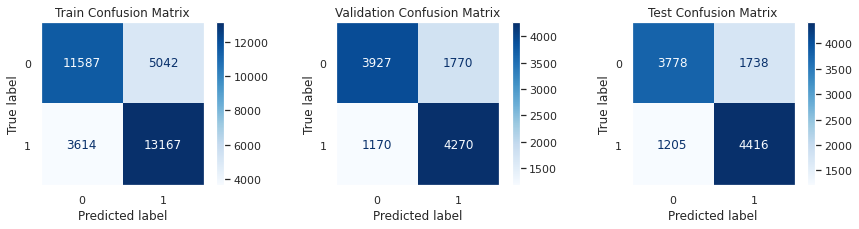

In [52]:
### Confusion matrix
plot_confusion(svc, 3, X_train_scaled, X_val_scaled, X_test_scaled)

In [53]:
# Random forest predictions on test set
rf_test_pred = rf.predict(X_test_scaled)

# Evaluate predictions
print(report(y_val, rf_val_pred))
print(report(y_test, rf_test_pred))

              precision    recall  f1-score   support

           0       0.78      0.70      0.74      5697
           1       0.72      0.79      0.75      5440

    accuracy                           0.74     11137
   macro avg       0.75      0.75      0.74     11137
weighted avg       0.75      0.74      0.74     11137

              precision    recall  f1-score   support

           0       0.77      0.70      0.73      5516
           1       0.73      0.79      0.76      5621

    accuracy                           0.75     11137
   macro avg       0.75      0.75      0.75     11137
weighted avg       0.75      0.75      0.75     11137



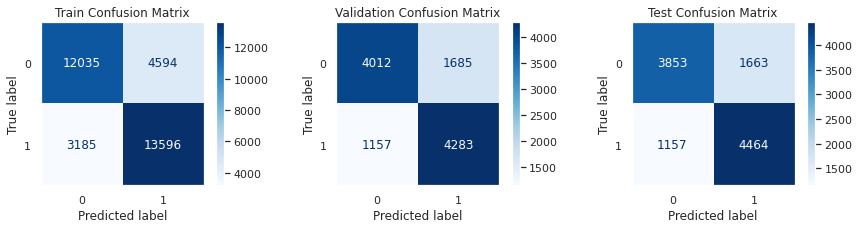

In [54]:
### Confusion matrix
plot_confusion(rf, 3, X_train_scaled, X_val_scaled, X_test_scaled)

##### We will be going with random forest as it outperformed SVM in both the validation and test sets. By examining its predictions, we may be able to see differences in demographics and behavior. This is actually a similar approach to segmentation, but we won't be segmenting customers. Instead, we are segmenting the unique offers that went out to customers.

In [55]:
# Normalize the entire dataset
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
print(X_scaled.shape)
X_scaled.head(2)

(55684, 15)


,reward,difficulty,duration,mobile,social,web,age,income,frequency,monetary,tenure,info_offer,disc_offer,bogo_offer,male
0,0.243966,-0.485470,0.22361,0.321859,-1.263613,0.50009,1.182039,1.591093,-0.253960,0.247765,-0.234072,-0.497788,-0.824874,1.233708,-1.139486
1,-0.640571,0.433579,0.22361,0.321859,-1.263613,0.50009,0.778388,0.198961,-1.066293,-0.507030,-1.024845,-0.497788,1.212306,-0.810565,0.877589


              precision    recall  f1-score   support

           0       0.78      0.71      0.75     27842
           1       0.74      0.80      0.77     27842

    accuracy                           0.76     55684
   macro avg       0.76      0.76      0.76     55684
weighted avg       0.76      0.76      0.76     55684



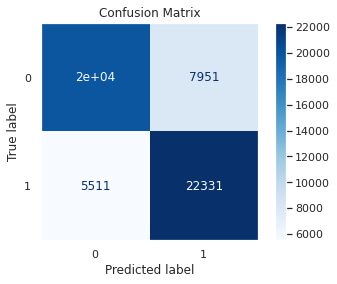

In [56]:
# Make predictions on the entire dataset
rf_pred = rf.predict(X_scaled)

# Evaluate predictions
print(report(y, rf_pred))
plot_confusion_matrix(rf, X_scaled, y, cmap='Blues')
plt.title('Confusion Matrix')
plt.grid(False);

In [57]:
# Inspect average values for each predicted class
X['prediction'] = rf_pred
label_means = X.groupby('prediction').mean()
label_means = label_means.append(X.mean()[:-1], ignore_index=True)
label_means

,reward,difficulty,duration,mobile,social,web,age,income,frequency,monetary,tenure,info_offer,disc_offer,bogo_offer,male
0,4.279545,8.531454,6.660027,0.827533,0.428037,0.821549,52.831864,62203.251712,5.927447,61.139050,14.438469,0.199906,0.405637,0.394457,0.634005
1,4.082821,6.894327,6.378575,0.972063,0.771647,0.781818,55.901889,68656.132356,10.199227,180.296398,21.458424,0.197477,0.404300,0.398223,0.506968
2,4.172563,7.641154,6.506968,0.906131,0.614898,0.799943,54.501401,65712.448818,8.250521,125.939043,18.256052,0.198585,0.404910,0.396505,0.564920


/home/tri/miniconda3/envs/minds/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


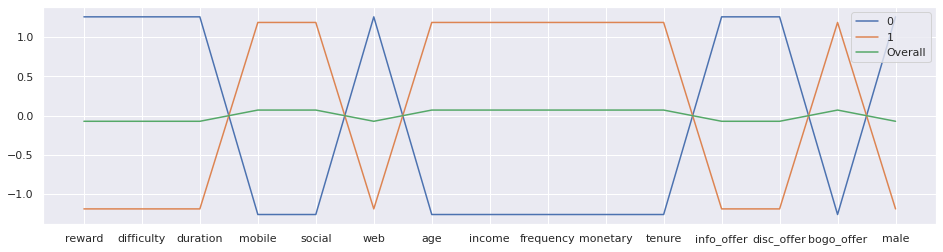

In [58]:
# Snake plot
pd.DataFrame(StandardScaler().fit_transform(label_means), index=[0, 1, 'Overall'], columns=label_means.columns).T.plot(figsize=(16, 4))
plt.xticks(range(15), label_means.columns);

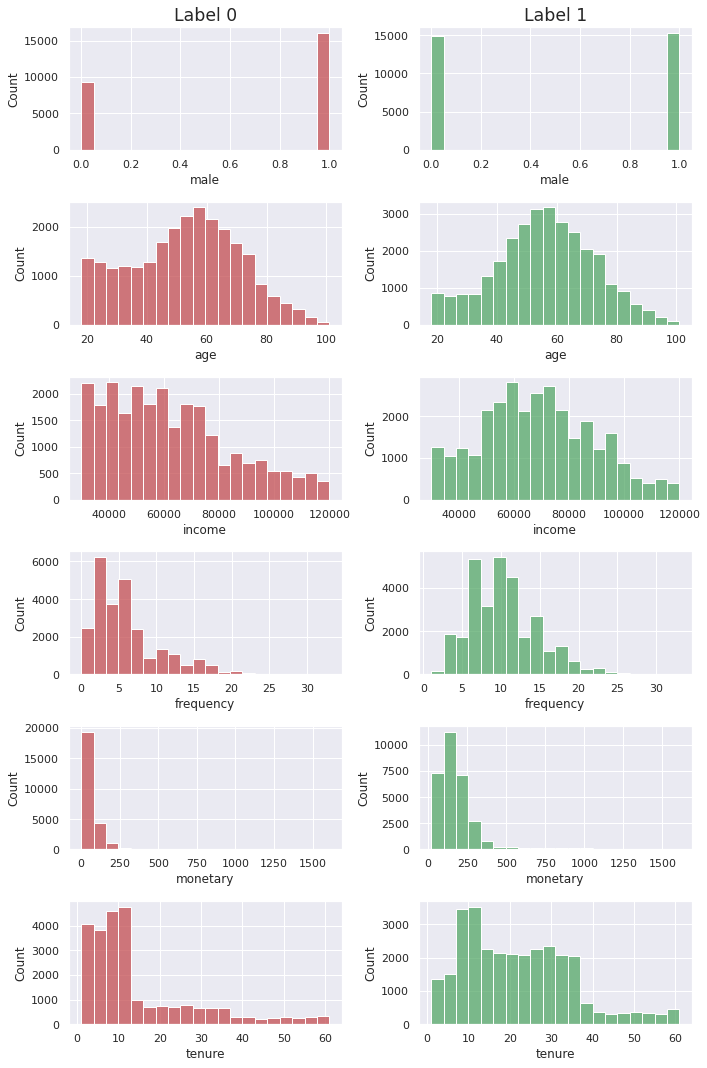

In [59]:
# Plot distribution for each feature by their predicted label
label0 = X.query('prediction == 0')
label1 = X.query('prediction == 1')
feats = ['male', 'age', 'income', 'frequency', 'monetary', 'tenure']

fig, ax = plt.subplots(6, 2, figsize=(10, 15))
ax[0, 0].set_title('Label 0', fontsize='x-large')
ax[0, 1].set_title('Label 1', fontsize='x-large')
for i in range(6):
    sns.histplot(x=label0[feats[i]], bins=20, color=sns.color_palette()[3], ax=ax[i, 0])
    sns.histplot(x=label1[feats[i]], bins=20, color=sns.color_palette()[2], ax=ax[i, 1])
plt.tight_layout()

In [60]:
del target_corr, label_means, label0, label1, feats, fig, ax, i
gc.collect()

49268

##### We can see that the classifier is capturing a lot of the same patterns seen in earlier analyses.
- Female customers are more likely to complete offers
- Customers under the `age` of 40 are more likely to NOT complete offers
- As `income` and spending habits increase, the customer is more likely to complete offers
- Users who have been using the app for more than a year are more likely to complete offers

##### Here are the parameters of our final classifier:
- `n_estimators`: 1000
- `max_samples`: 0.6
- `max_features`: 0.75
- `max_depth`: 10
- `min_samples_split`: 40
- `min_samples_leaf`: 20

##### So the random forest classifier built 1000 trees, each using a 60% subsample of the training dataset and 75% subsample of the feature set. Each tree grew to a maximum depth of 10 and all of its leaf nodes have at least 20 data points in them. In classifying a new data point, the classifier ensembles the results of all 1000 trees and votes on the output.

## <a id="conc">Section IV: Conclusion</a>

In this notebook, I built a classifier that predicts whether a user will complete an offer. The process began with some data preprocessing, which included extracting the received offers (the data of interest), encoding the categorical variables into numerical data, creating the target label (defined as 1 if the user viewed and then completed the offer or 0 otherwise), and balancing the label classes.

I also inspected feature correlation in order to create a separate feature set for logistic regression, which has an assumption of non-multicollinearity. The last step was to split the data into 3 sets and normalize the features in all 3 sets:
- Training set (60%) - used to fit the machine learning models
- Validation set (20%) - used to validate model building and parameter tuning
- Test set (20%) - holdout set for the final test

Then it was on to building models. Out of the 6 models tried - [logistic regression](#clfr3), [k-nearest neighbors](#clfr4), [support vector machines](#clfr5), [decision tree](#clfr6), [random forest](#clfr7), and [light gradient boosting machines](#clfr8) - the random forest classifier had the best prediction performance with an F1 score of 0.74 on the validation set and 0.75 on the test set.

Upon inspecting the final classifier's predictions, we also saw that it captured a lot of the patterns seen in the analyses of previous notebooks.

### Save data

In [61]:
df.to_pickle('../data/out3/train.pkl')
joblib.dump(scaler, '../data/out3/scaler.pkl')
joblib.dump(rf, '../data/out3/rfc.pkl')
df.shape

(55684, 16)